In [1]:
import os
import sys

import contextily as cx
import joblib
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

os.chdir(os.path.dirname(os.getcwd()))

from src import largest_weakly_connected_component
import src

# Mobility network

In [2]:
portcalls = joblib.load('data/portcalls_v3.pkl')
selected = np.load('data/selected.npy', allow_pickle=True)
portcalls_selected = portcalls.loc[lambda x: x['ship'].isin(selected)]

edges = pd.concat([pd.DataFrame({'source': ship_df['port'].shift(1), 'target': ship_df['port']}).dropna() for _, ship_df in portcalls_selected.groupby('ship')])
G = nx.from_pandas_edgelist(edges, create_using=nx.MultiDiGraph)
Gc = largest_weakly_connected_component(G)

## Figure
### Obtain UNLOCODE

In [3]:
objs = [
    pd.read_csv(
        f'data/raw/2021-1 UNLOCODE CodeListPart{i}.csv', encoding_errors='ignore', 
        names=['Ch', 'LOCODE_country', 'LOCODE_city', 'Name', 'NameWoDiacritics', 'SubDiv', 'Function', 'Status', 'Date', 'IATA', 'Coordinates', 'Remarks']
    )
    for i in (1,2,3)
]
nodes = pd.concat(objs).dropna(subset=['Coordinates'])

Latitude = list()
Longitude = list()
for lat_str, long_str in nodes['Coordinates'].str.split():
    sign_lat = -1 if lat_str[-1] == 'S' else 1
    sign_long = -1 if long_str[-1] == 'W' else 1
    Latitude.append(sign_lat * float(lat_str[:-1]) / 100)
    Longitude.append(sign_long * float(long_str[:-1]) / 100)
labels = nodes['LOCODE_country'] + nodes['LOCODE_city']

data = {'x': Longitude, 'y': Latitude, 'label': labels}
def get_strength(x):
    return [Gc.degree(node) for node in x.index]

nodes = (
    pd.DataFrame(data)
    .drop_duplicates(subset='label')
    .set_index('label')
    .loc[lambda x: x.index.isin(Gc)]
    .assign(strength=get_strength)
    .loc[lambda x: x.strength > 10]
)
nodes

,x,y,strength
label,,,
BEANR,4.25,51.13,10405
BEBON,4.14,51.06,28
BEBGS,3.14,51.13,812
BEGNK,5.30,50.58,44
BEGNE,3.43,51.03,2821
...,...,...,...
SEVST,16.33,59.37,548
SEVVK,16.38,57.45,48
SEVBY,18.18,57.38,38


### Select edges with known location

In [4]:
def select_only_edges_with_location(x):
    values = nodes.index
    return x['source'].isin(values) & x['target'].isin(values)
    
selected_edges = (
    edges
    .loc[select_only_edges_with_location]
    .value_counts()
    .reset_index()
    .rename(columns={0:'weight'})
)
selected_edges

,source,target,weight
0,GBLRP,GBBEL,3955
1,GBBEL,GBLRP,3954
2,FRBON,ITSTE,3101
3,ITSTE,FRBON,3099
4,FRCQF,FRCQF,1902
...,...,...,...
19039,EEPLS,NOMQN,1
19040,EEPLS,NOMON,1
19041,ITNAP,ITMFR,1
19042,EEPLS,MTMAR,1


### Plot

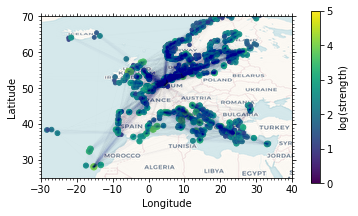

In [6]:
cmap = cm.get_cmap('viridis')
colors = [cmap(i/5, alpha=i/5) for i in nodes.strength]
fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
for edge in selected_edges.itertuples():
    source_location = nodes.loc[edge.source]
    target_location = nodes.loc[edge.target]
    if edge.weight > 1000:
        alpha=.05
    elif edge.weight > 100:
        alpha=.02
    elif edge.weight > 10:
        alpha=.01
    else:
        alpha=.005
    ax.plot((source_location.x, target_location.x), (source_location.y, target_location.y), color='darkblue', alpha=alpha, lw=2*np.log10(edge.weight))
ax.scatter(x=nodes.x, y=nodes.y, c=np.log10(nodes.strength), s=np.log10(nodes.strength)*10, cmap='viridis', norm=Normalize(0, 5), alpha=1)
fig.colorbar(cm.ScalarMappable(norm=Normalize(0, 5), cmap='viridis'), ax=ax, shrink=0.80, label=r'$\log(\mathrm{strength})$')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_xlim(-30, 40)
ax.set_ylim(25, 70)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
cx.add_basemap(ax, crs='WGS84', attribution=False, zoom=3, interpolation='sinc', source=cx.providers.CartoDB.Voyager)

fig.savefig('fig/network.pdf')

## Stats
### Calculate distance distribution

In [ ]:
!printf '%s\n' 'load_undirected /data/bruingjde/on-going/portcall/cache/network.edges' 'dist_distri' > "cache/input.txt"
nx.write_edgelist(nx.convert_node_labels_to_integers(nx.Graph(Gc)), 'cache/network.edges', data=False)
! /data/bruingjde/teexgraph/teexgraph < cache/input.txt > cache/output.txt
output_teexgraph = pd.read_csv('cache/output.txt', sep='\t', names=['distance', 'counts'])
os.remove('cache/network.edges')
os.remove('cache/input.txt')
os.remove('cache/output.txt')
output_teexgraph

### Summary

In [ ]:
{
    'number of nodes': G.number_of_nodes(),
    'number of nodes in GC': Gc.number_of_nodes(),
    'number of edges': G.number_of_edges(),
    'fraction of edges in GC': Gc.number_of_edges(),
    'density': nx.density(nx.Graph(Gc)),
    'diameter': output_teexgraph['distance'].max(),
    'average distance': np.average(output_teexgraph['distance'], weights=output_teexgraph['counts']),
    'clustering coefficient': nx.average_clustering(nx.Graph(Gc)),
    'degree assortativity': nx.degree_assortativity_coefficient(nx.Graph(Gc))
}